# **Installing Necessary libraries first**

In [1]:
!pip install -q datasets
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.9 MB/s eta 0:00:00


# Importing Necessary Libraries

In [2]:
import numpy as np
import torch
import cv2
import torch.nn as nn
from transformers import ViTModel,ViTConfig
from torchvision import transforms
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
checkpoint='google/vit-base-patch16-224-in21k'

# Give a look at the datasets

In [3]:
from datasets import load_dataset

dataset=load_dataset('Matthijs/snacks')
print(dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset snacks downloaded and prepared to /root/.cache/huggingface/datasets/Matthijs___snacks/default/0.0.1/c0ce49075aa469a098a5f2e3455941c894e02e1c9bf642d4d33e6c51460ff590. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4838
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 952
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 955
    })
})


In [4]:
#Now writing a dataset for this dataset
import torch.nn as nn

class Snacks_Dataset(torch.utils.data.Dataset):
  def __init__(self,dataset,transform=None):
    self.dataset=dataset
    self.transform=transform
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self,idx):
    image=self.dataset[idx]['image']
    labels=self.dataset[idx]['label']

    if self.transform!=None:
      image=self.transform(image)

      return image,labels
    return image,labels


In [5]:
from torchvision import transforms

transform=transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224,224),antialias=True),
        transforms.Normalize(mean=[0.5,0.5,0.5],
                             std=[0.5,0.5,0.5]
                             )
    ]
)

In [6]:
trainset=Snacks_Dataset(dataset['train'],transform)
validset=Snacks_Dataset(dataset['validation'],transform)
testset=Snacks_Dataset(dataset['test'],transform)

In [7]:
print(f"Length of the Training Set {len(trainset)}")
print(f"Length of the Validation Set {len(validset)}")
print(f"Length of the Test Set {len(testset)}")

Length of the Training Set 4838
Length of the Validation Set 955
Length of the Test Set 952


# DataLoader

In [8]:
trainloader=torch.utils.data.DataLoader(trainset,batch_size=16,shuffle=True)
validloader=torch.utils.data.DataLoader(validset,batch_size=16,shuffle=True)

In [9]:
for data in trainloader:
  image,label=data
  break

print(f"One batch image size: {image.shape} ")
print(f"One batch label size: {label.shape}")

One batch image size: torch.Size([16, 3, 224, 224]) 
One batch label size: torch.Size([16])


# **Creating Model**

In [10]:

class SnackVit(nn.Module):
  def __init__(self,config=ViTConfig(),num_labels=20,checkpoint=checkpoint):
    super(SnackVit,self).__init__()
    self.vit=ViTModel.from_pretrained(checkpoint,add_pooling_layer=False)
    self.classifier=nn.Linear(config.hidden_size,num_labels)

  def forward(self,image):
    x=self.vit(image)['last_hidden_state']
    out=self.classifier(x[:,0,:])

    return out

In [11]:
model=SnackVit()
model.to('cuda');

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
model(torch.randn(16,3,224,224).to('cuda')).shape

torch.Size([16, 20])

In [13]:
def train_function(model,trainloader,optimizer):
  train_loss=0.0
  train_acc=0.0
  model.train()
  for data in tqdm(trainloader):
    images,keys=data

    images=images.to('cuda')
    keys=keys.to('cuda')

    logits=model(images)
    loss=nn.CrossEntropyLoss()(logits,keys)
    train_acc+=(logits.argmax(dim=1)==keys).sum().item()
    train_loss+=loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



  return train_loss/len(trainloader.dataset),train_acc/len(trainloader.dataset)

In [14]:
def valid_function(model,validloader):
  valid_loss=0.0
  valid_acc=0.0
  model.eval()
  with torch.no_grad():
    for data in tqdm(validloader):
      images,keys=data
      images=images.to('cuda')
      keys=keys.to('cuda')

      logits=model(images)
      loss=nn.CrossEntropyLoss()(logits,keys)
      valid_acc+=(logits.argmax(dim=1) == keys).sum().item()
      valid_loss+=loss.item()

    return valid_loss/len(validloader.dataset),valid_acc/len(validloader.dataset)

In [16]:
epochs=20
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)
best_valid_acc=np.Inf
for i in range(epochs):
  train_loss,train_acc=train_function(model,trainloader,optimizer)
  valid_loss,valid_acc=valid_function(model,validloader)
  if valid_acc<best_valid_acc:
    torch.save(model.state_dict(),"Snack Model.pt")
    best_valid_acc=valid_acc
    print("Model Saved")
  print(f'Epoch{i+1}/{epochs} Training Loss: {train_loss} Training Accuracy {train_acc} Validation Loss: {valid_loss} Validation Acc: {valid_acc}')

100%|██████████| 60/60 [00:15<00:00,  3.97it/s]


Model Saved
Epoch1/20 Training Loss: 0.008734561346237228 Training Accuracy 0.9716825134353039 Validation Loss: 0.025773995763656358 Validation Acc: 0.8942408376963351


100%|██████████| 60/60 [00:15<00:00,  3.98it/s]


Epoch2/20 Training Loss: 0.005038424415622444 Training Accuracy 0.9809838776353865 Validation Loss: 0.023497726339164204 Validation Acc: 0.9047120418848168


100%|██████████| 60/60 [00:15<00:00,  3.97it/s]


Model Saved
Epoch3/20 Training Loss: 0.005208466244948494 Training Accuracy 0.9774700289375775 Validation Loss: 0.027167569872245428 Validation Acc: 0.8921465968586387


100%|██████████| 60/60 [00:15<00:00,  3.99it/s]


Epoch4/20 Training Loss: 0.0029993140414540445 Training Accuracy 0.9853245142620918 Validation Loss: 0.025811515397426345 Validation Acc: 0.8952879581151832


100%|██████████| 60/60 [00:15<00:00,  3.99it/s]


Epoch5/20 Training Loss: 0.001195271068251468 Training Accuracy 0.9952459694088466 Validation Loss: 0.02613634745887827 Validation Acc: 0.9068062827225131


100%|██████████| 60/60 [00:14<00:00,  4.00it/s]


Epoch6/20 Training Loss: 0.0007076618503128518 Training Accuracy 0.9981397271599834 Validation Loss: 0.028660380362450142 Validation Acc: 0.8921465968586387


100%|██████████| 60/60 [00:15<00:00,  3.96it/s]


Model Saved
Epoch7/20 Training Loss: 0.0052602862289160765 Training Accuracy 0.9776767259198016 Validation Loss: 0.0410065454835589 Validation Acc: 0.8366492146596859


100%|██████████| 60/60 [00:17<00:00,  3.51it/s]


Epoch8/20 Training Loss: 0.0044219813805493925 Training Accuracy 0.982637453493179 Validation Loss: 0.03413163321921651 Validation Acc: 0.8534031413612565


100%|██████████| 60/60 [00:16<00:00,  3.66it/s]


Epoch9/20 Training Loss: 0.00448715199451507 Training Accuracy 0.9799503927242662 Validation Loss: 0.032842157814281146 Validation Acc: 0.8722513089005236


100%|██████████| 60/60 [00:15<00:00,  3.78it/s]


Epoch10/20 Training Loss: 0.002583782763500267 Training Accuracy 0.9902852418354692 Validation Loss: 0.03132798983203491 Validation Acc: 0.8795811518324608


100%|██████████| 60/60 [00:15<00:00,  3.91it/s]


Epoch11/20 Training Loss: 0.001113379798516163 Training Accuracy 0.9956593633732947 Validation Loss: 0.03043722121864167 Validation Acc: 0.8890052356020942


100%|██████████| 60/60 [00:15<00:00,  3.84it/s]


Epoch12/20 Training Loss: 0.0028270056123330146 Training Accuracy 0.9882182720132286 Validation Loss: 0.03233840376753067 Validation Acc: 0.8806282722513089


100%|██████████| 60/60 [00:15<00:00,  3.97it/s]


Epoch13/20 Training Loss: 0.0027408203165298663 Training Accuracy 0.9888383629599008 Validation Loss: 0.03928941802965253 Validation Acc: 0.8575916230366493


100%|██████████| 60/60 [00:15<00:00,  3.98it/s]


Epoch14/20 Training Loss: 0.0016336095002593427 Training Accuracy 0.9933856965688301 Validation Loss: 0.033629184596591595 Validation Acc: 0.8670157068062827


100%|██████████| 60/60 [00:15<00:00,  4.00it/s]


Epoch15/20 Training Loss: 0.004475973691049588 Training Accuracy 0.9818106655642828 Validation Loss: 0.03684811323139992 Validation Acc: 0.8575916230366493


100%|██████████| 60/60 [00:14<00:00,  4.00it/s]


Epoch16/20 Training Loss: 0.002508170615372322 Training Accuracy 0.9884249689954526 Validation Loss: 0.03592975985609892 Validation Acc: 0.8586387434554974


100%|██████████| 60/60 [00:14<00:00,  4.01it/s]


Epoch17/20 Training Loss: 0.0019211898511497026 Training Accuracy 0.9921455146754857 Validation Loss: 0.030087509137061447 Validation Acc: 0.8827225130890053


100%|██████████| 60/60 [00:15<00:00,  3.97it/s]


Epoch18/20 Training Loss: 0.0004095851504875315 Training Accuracy 0.9981397271599834 Validation Loss: 0.03329770504557942 Validation Acc: 0.8795811518324608


100%|██████████| 60/60 [00:14<00:00,  4.03it/s]


Epoch19/20 Training Loss: 0.0009591069638126758 Training Accuracy 0.9962794543199669 Validation Loss: 0.03275581988584036 Validation Acc: 0.8869109947643979


100%|██████████| 60/60 [00:14<00:00,  4.03it/s]

Epoch20/20 Training Loss: 0.0006439673011997771 Training Accuracy 0.9979330301777594 Validation Loss: 0.03438315857445617 Validation Acc: 0.8670157068062827


# Prediction on Test Image

In [18]:
print(dataset["train"].features['label'].names)

['apple', 'banana', 'cake', 'candy', 'carrot', 'cookie', 'doughnut', 'grape', 'hot dog', 'ice cream', 'juice', 'muffin', 'orange', 'pineapple', 'popcorn', 'pretzel', 'salad', 'strawberry', 'waffle', 'watermelon']


In [19]:
labels = dataset["train"].features["label"].names
num_labels = len(dataset["train"].features["label"].names)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(label2id)
print(id2label)

{'apple': 0, 'banana': 1, 'cake': 2, 'candy': 3, 'carrot': 4, 'cookie': 5, 'doughnut': 6, 'grape': 7, 'hot dog': 8, 'ice cream': 9, 'juice': 10, 'muffin': 11, 'orange': 12, 'pineapple': 13, 'popcorn': 14, 'pretzel': 15, 'salad': 16, 'strawberry': 17, 'waffle': 18, 'watermelon': 19}
{0: 'apple', 1: 'banana', 2: 'cake', 3: 'candy', 4: 'carrot', 5: 'cookie', 6: 'doughnut', 7: 'grape', 8: 'hot dog', 9: 'ice cream', 10: 'juice', 11: 'muffin', 12: 'orange', 13: 'pineapple', 14: 'popcorn', 15: 'pretzel', 16: 'salad', 17: 'strawberry', 18: 'waffle', 19: 'watermelon'}


In [20]:
def predict_on_test(image):
  device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  transform=transforms.Compose(
      [
          transforms.ToTensor(),
          transforms.Resize((224,224)),
          transforms.Normalize(mean=[0.5,0.5,0.5],
                               std=[0.5,0.5,0.5]
                               )
      ]
  )
  image=transform(image)
  output=model(image.unsqueeze(0).to(device))
  prediction=output.argmax(dim=1).item()

  return id2label[prediction]


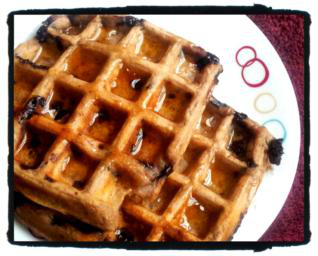

In [21]:
dataset['test'][900]['image']

In [22]:
print(predict_on_test(dataset['test'][900]['image']))

waffle


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


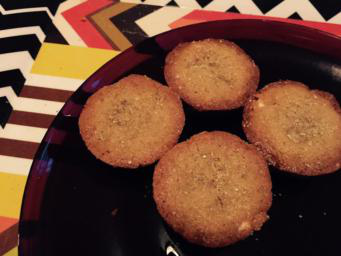

In [23]:
dataset['test'][250]['image']

In [24]:
print(predict_on_test(dataset['test'][250]['image']))

cookie


In [ ]:
"""
epochs=20
criterion=nn.CrossEntropyLoss().to('cuda')
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)
epochs=20
for i in range(epochs):
        total_acc_train = 0
        total_loss_train = 0.0

        for train_image, train_label in tqdm(trainloader):
            output = model(train_image.to('cuda'))
            loss = criterion(output, train_label.to('cuda'))
            acc = (output.argmax(dim=1) == train_label.to('cuda')).sum().item()
            total_acc_train += acc
            total_loss_train += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print(f'Epochs: {i + 1} | Loss: {total_loss_train / len(trainset): .3f} | Accuracy: {total_acc_train / len(trainset): .3f}')
